Restarted stellar (Python 3.11.9)

In [ ]:
os.chdir('/home/oban/Desktop/Volga/stellar-classification')
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, DataLoader, 
                              WeightedRandomSampler, random_split)

from torchmetrics.classification import F1Score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
hdul = fits.open('data/dataset3_subset2.fits')
dataset = hdul[1].data
hdul.close()

In [ ]:
# trsvchn's answer on stackoverflow at: https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

class GaussianNoise(torch.nn.Module):
    def __init__(self, mean: float, sigma_r: tuple):
        super().__init__()
        self.mean = mean
        self.sigma_r = sigma_r

    def forward(self, spectra):
        sigma = torch.Tensor((1)).uniform_(*self.sigma_r).cuda()
        noise = self.mean + torch.randn_like(spectra).cuda() * sigma
        out = spectra + noise
        return out

def split_dataset(data, label, dataset, split, **kwargs):
    x = data[split]
    y = label[split]
    return dataset((x,y),**kwargs)

In [ ]:
flux_numpy = dataset.FLUX.newbyteorder().byteswap()

from eval_utils import label_field, stellar_metrics

label_f = label_field(dataset, regr=False, new=True)
# label_f_old = label_field(dataset_old, regr=False, new=False)

classes = label_f.classes
indices = label_f.ord_to_idx(classes)

splits = list(range(0,len(dataset)))

train, test_val = train_test_split(splits, test_size=0.3, 
                                   random_state=1337, stratify=indices)

ones = np.where(np.unique(classes[test_val],return_counts=True)[1] == 1)

if len(ones) != 0: 
    for i in ones[0]:
        label = label_f.idx_to_ord(i)
        idx = np.where(classes[train] == label)[0][-1]
        real_idx = train.pop(idx)
        test_val.append(real_idx)

val, test = train_test_split(test_val, test_size=0.5, 
                             random_state=1337, stratify=indices[test_val])

assert sum([len(set(classes[i])) for i in [train, val, test]]) % 3 == 0

In [ ]:
flux = torch.tensor(flux_numpy).cuda().float()
labels = torch.tensor(indices).cuda().int() #indices

gaussian_noise = GaussianNoise(mean=0,sigma_r=(0.01,0.05))

train_iter = split_dataset(flux, labels, CustomTensorDataset, 
                           train, transform=gaussian_noise)

val_iter = split_dataset(flux, labels, CustomTensorDataset, val)

test_iter = split_dataset(flux, labels, CustomTensorDataset, test)

weights = pd.Series(indices[train]).value_counts()

random_sample = WeightedRandomSampler(weights=max(weights)/weights[indices[train]].values,
                                      num_samples=len(indices[train]))

train_loader = DataLoader(train_iter, 128, sampler=random_sample)
val_loader = DataLoader(val_iter, 128)
test_loader = DataLoader(test_iter, 128)

In [ ]:
def trainer(dataloader, model, loss, optimizer):
    losses = []
    preds = []
    actuals = []
    model.train()
    for fluxes, labels in dataloader:

        labels = labels.type(torch.LongTensor).cuda()
        fluxes = fluxes.cuda()

        optimizer.zero_grad()
        class_scores = model(fluxes)
        train_loss = loss(class_scores, labels)
        train_loss.backward()
        optimizer.step()
    
        losses.append(train_loss.item())
        preds.extend(class_scores.argmax(dim=1).tolist())
        actuals.extend(labels.tolist())

    inter_sm = stellar_metrics(label_f, preds, actuals, True, False)
    f1 = inter_sm.f1_macro()
    qwk = inter_sm.two_stage_qwk('q')

    return losses, f1, qwk

def validator(dataloader, model, loss, test=False):
    losses = []
    preds = []
    actuals = []
    model.eval()
    with torch.no_grad():
        if not test:
            for fluxes, labels in dataloader:
                labels = labels.type(torch.LongTensor).cuda()
                fluxes = fluxes.cuda()

                class_scores = model(fluxes)
                val_loss = loss(class_scores, labels)
                losses.append(val_loss.item())
                preds.extend(class_scores.argmax(dim=1).tolist())
                actuals.extend(labels.tolist())

            inter_sm = stellar_metrics(label_f, preds, actuals, True, False)
            f1 = inter_sm.f1_macro()
            qwk = inter_sm.two_stage_qwk('q')

            return losses, f1, qwk

        if test:
            for fluxes, labels in dataloader:
                labels = labels.type(torch.LongTensor).cuda()
                fluxes = fluxes.cuda()

                class_scores = model(fluxes)
                class_preds = class_scores.argmax(dim=1)
                preds.extend(class_preds.tolist())
                actuals.extend(labels.tolist())

            return preds, actuals

class2coords = torch.tensor(
    label_f.to_regr(np.unique(classes),idx=False),
    dtype=torch.float32)

class OrdinalLoss(nn.Module):
    def __init__(self, class2coords, alpha, betas=[1,1]):
        super().__init__()
        # register as a buffer so it moves with .to(device), but is not trained
        self.register_buffer('coords', class2coords)  
        self.alpha = torch.tensor(alpha).cuda()
        self.betas = torch.tensor(betas).cuda()

    def forward(self, logits, target):
        probs = logits.softmax(dim=1)
        pred_xy = probs @ self.coords
        true_xy = self.coords[target]

        loss_xent = F.cross_entropy(logits, target)
        loss_ord = F.mse_loss(self.betas*pred_xy, self.betas*true_xy)
        return (1-self.alpha)*loss_xent + self.alpha*loss_ord

In [ ]:
# from torchmetrics.regression import MeanAbsoluteError
from models.conv1d import ResNet1D50

torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
torch.cuda.manual_seed_all(1337)

resnet1d = ResNet1D50(
    num_classes=len(label_f.unique),
    in_channels=1
    ).to('cuda')

custom_loss = OrdinalLoss(class2coords, 0.75, betas=[1,1.5]).cuda()

adamw = torch.optim.AdamW(resnet1d.parameters(), lr=1e-4, betas=[0.9,0.75])

In [ ]:
folder_name = 'resnet_test2'
path = f'models/weights/conv1d/cls/{folder_name}'
if not os.path.exists(path):
    os.mkdir(path)

epochs = 200

losses = []
metrics = []

best_f1 = 0.4

for i in range(epochs):
    tr_l, tr_f1, tr_qwk = trainer(train_loader, resnet1d, custom_loss, adamw)
    vl_l, vl_f1, vl_qwk = validator(val_loader, resnet1d, custom_loss)

    losses.extend([tr_l, vl_l])
    metrics.append((
        np.mean(tr_l), tr_f1, tr_qwk,
        np.mean(vl_l), vl_f1, vl_qwk
    ))

    if vl_f1 > best_f1 * 1.01:
        best_f1 = vl_f1
        print(f"New best model found at epoch {i}")
        torch.save(resnet1d.state_dict(), f'{path}/best_conv1d_cls_{i}.pth.tar')

    if i%5 == 0:
        printout = '\t|\t'.join([str(np.round(x,2)) for x in metrics[-1]])
        print(f'''{i}/{epochs} \t|\t: {printout}''')

0/200 	|	: 3.16	|	0.06	|	[0.65 0.15]	|	5.81	|	0.0	|	[0.14 0.09]
5/200 	|	: 0.91	|	0.47	|	[0.97 0.71]	|	1.09	|	0.35	|	[0.95 0.36]
New best model found at epoch 9
10/200 	|	: 0.67	|	0.6	|	[0.99 0.81]	|	0.78	|	0.41	|	[0.95 0.56]
New best model found at epoch 12
New best model found at epoch 15
15/200 	|	: 0.54	|	0.67	|	[0.99 0.85]	|	0.82	|	0.44	|	[0.96 0.54]
New best model found at epoch 17
20/200 	|	: 0.48	|	0.72	|	[0.99 0.89]	|	0.69	|	0.4	|	[0.93 0.54]
New best model found at epoch 21
New best model found at epoch 24
New best model found at epoch 25
25/200 	|	: 0.41	|	0.75	|	[0.99 0.92]	|	0.7	|	0.52	|	[0.98 0.75]
30/200 	|	: 0.39	|	0.76	|	[1.   0.92]	|	0.75	|	0.49	|	[0.98 0.7 ]
New best model found at epoch 33
35/200 	|	: 0.35	|	0.79	|	[1.   0.92]	|	0.7	|	0.5	|	[0.98 0.7 ]
40/200 	|	: 0.33	|	0.79	|	[1.   0.93]	|	0.68	|	0.55	|	[0.98 0.68]
45/200 	|	: 0.32	|	0.81	|	[1.   0.94]	|	0.67	|	0.53	|	[0.97 0.68]
50/200 	|	: 0.3	|	0.82	|	[1.   0.95]	|	0.71	|	0.52	|	[0.98 0.71]
55/200 	|	: 0.28	|	0

In [ ]:
# path = 'models/weights/conv1d/cls/final6_test'
best_i = 172

classifier3 = ResNet1D50(
    num_classes=len(label_f.unique),
    in_channels=1
    ).to('cuda')
    
classifier3.load_state_dict(torch.load(f'{path}/best_conv1d_cls_{best_i}.pth.tar'))

<All keys matched successfully>

F1 Macro: 58.43%
Mean Absolute Error: 0.20
Q-Weighted Kappa: 97.15%, 68.96%


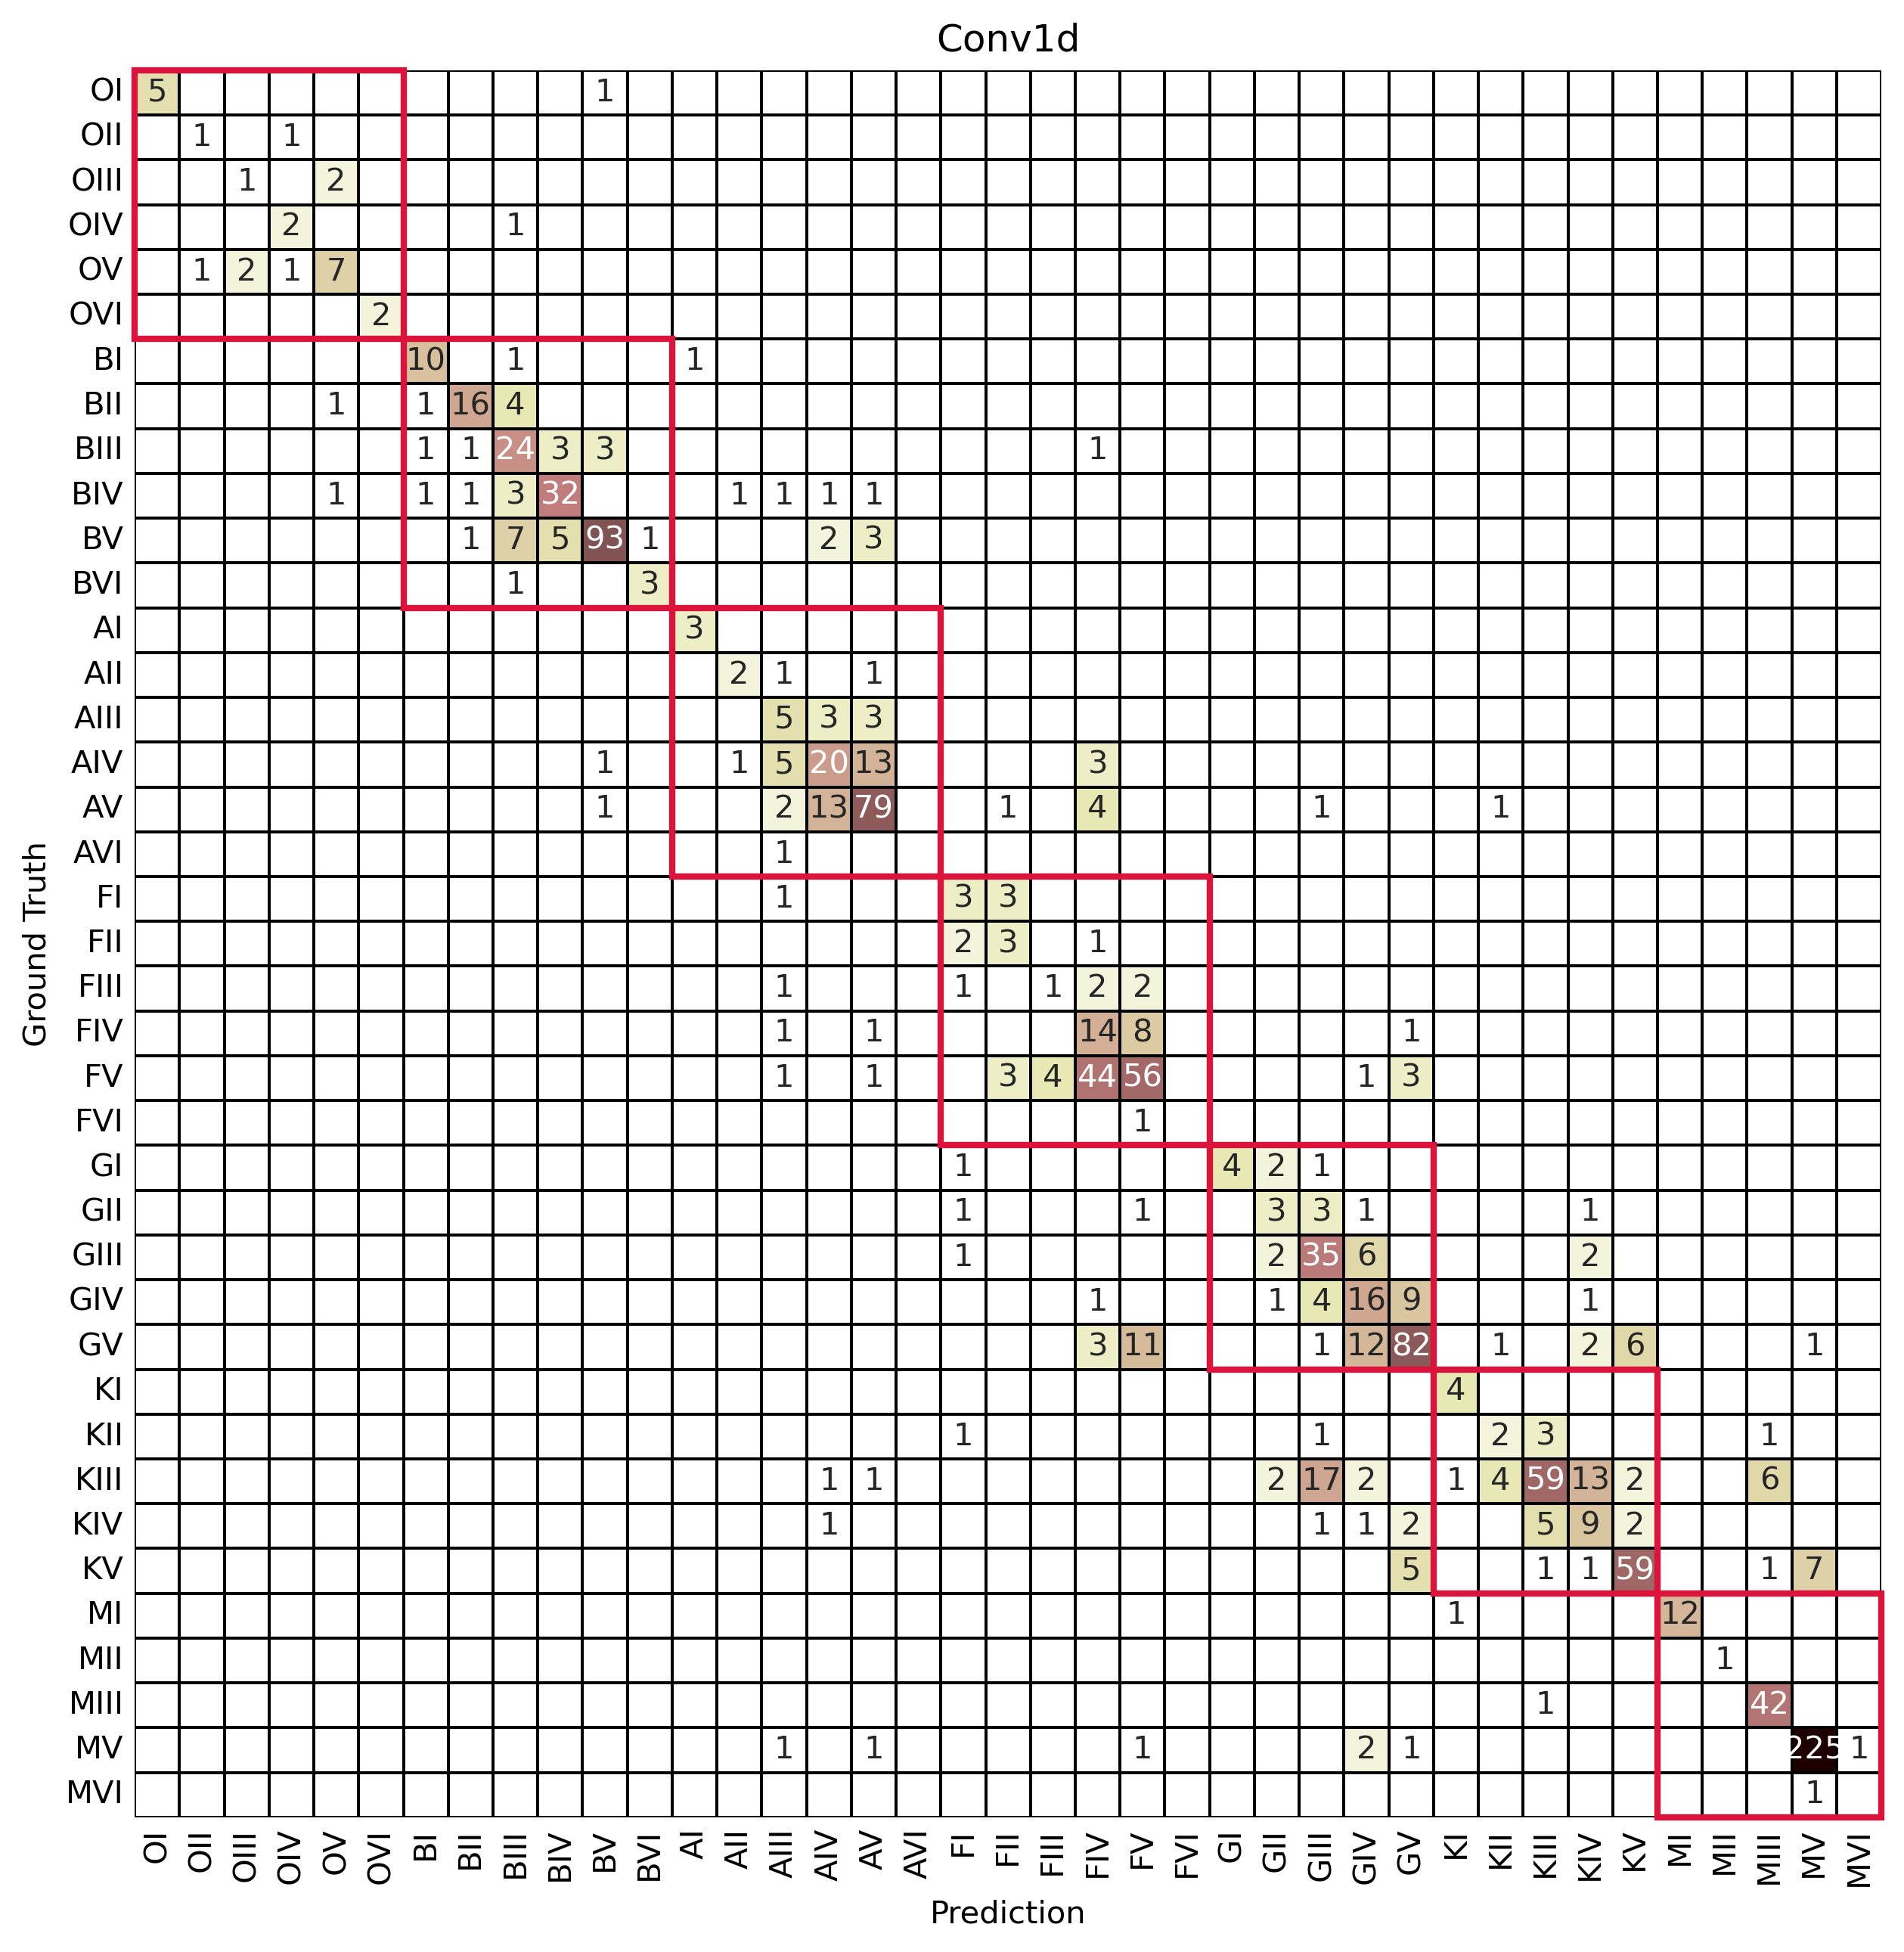

In [ ]:
preds, actuals = validator(test_loader, classifier3, custom_loss, test=True)
sm = stellar_metrics(label_f, preds, actuals, True, False)

sm.draw_cm('Conv1d', 300, False)

print(f'F1 Macro: {sm.f1_macro():.2%}')
print(f'Mean Absolute Error: {sm.mae():.2f}')
print(f'Q-Weighted Kappa: {sm.two_stage_qwk("q")[0]:.2%}, {sm.two_stage_qwk("q")[1]:.2%}')

In [ ]:
# path = 'models/weights/conv1d/cls/final6_test'
best_i = 81

classifier3 = ResNet1D50(
    num_classes=len(label_f.unique),
    in_channels=1
    ).to('cuda')
    
classifier3.load_state_dict(torch.load(f'{path}/best_conv1d_cls_{best_i}.pth.tar'))

<All keys matched successfully>

F1 Macro: 56.75%
Mean Absolute Error: 0.21
Q-Weighted Kappa: 97.98%, 67.18%


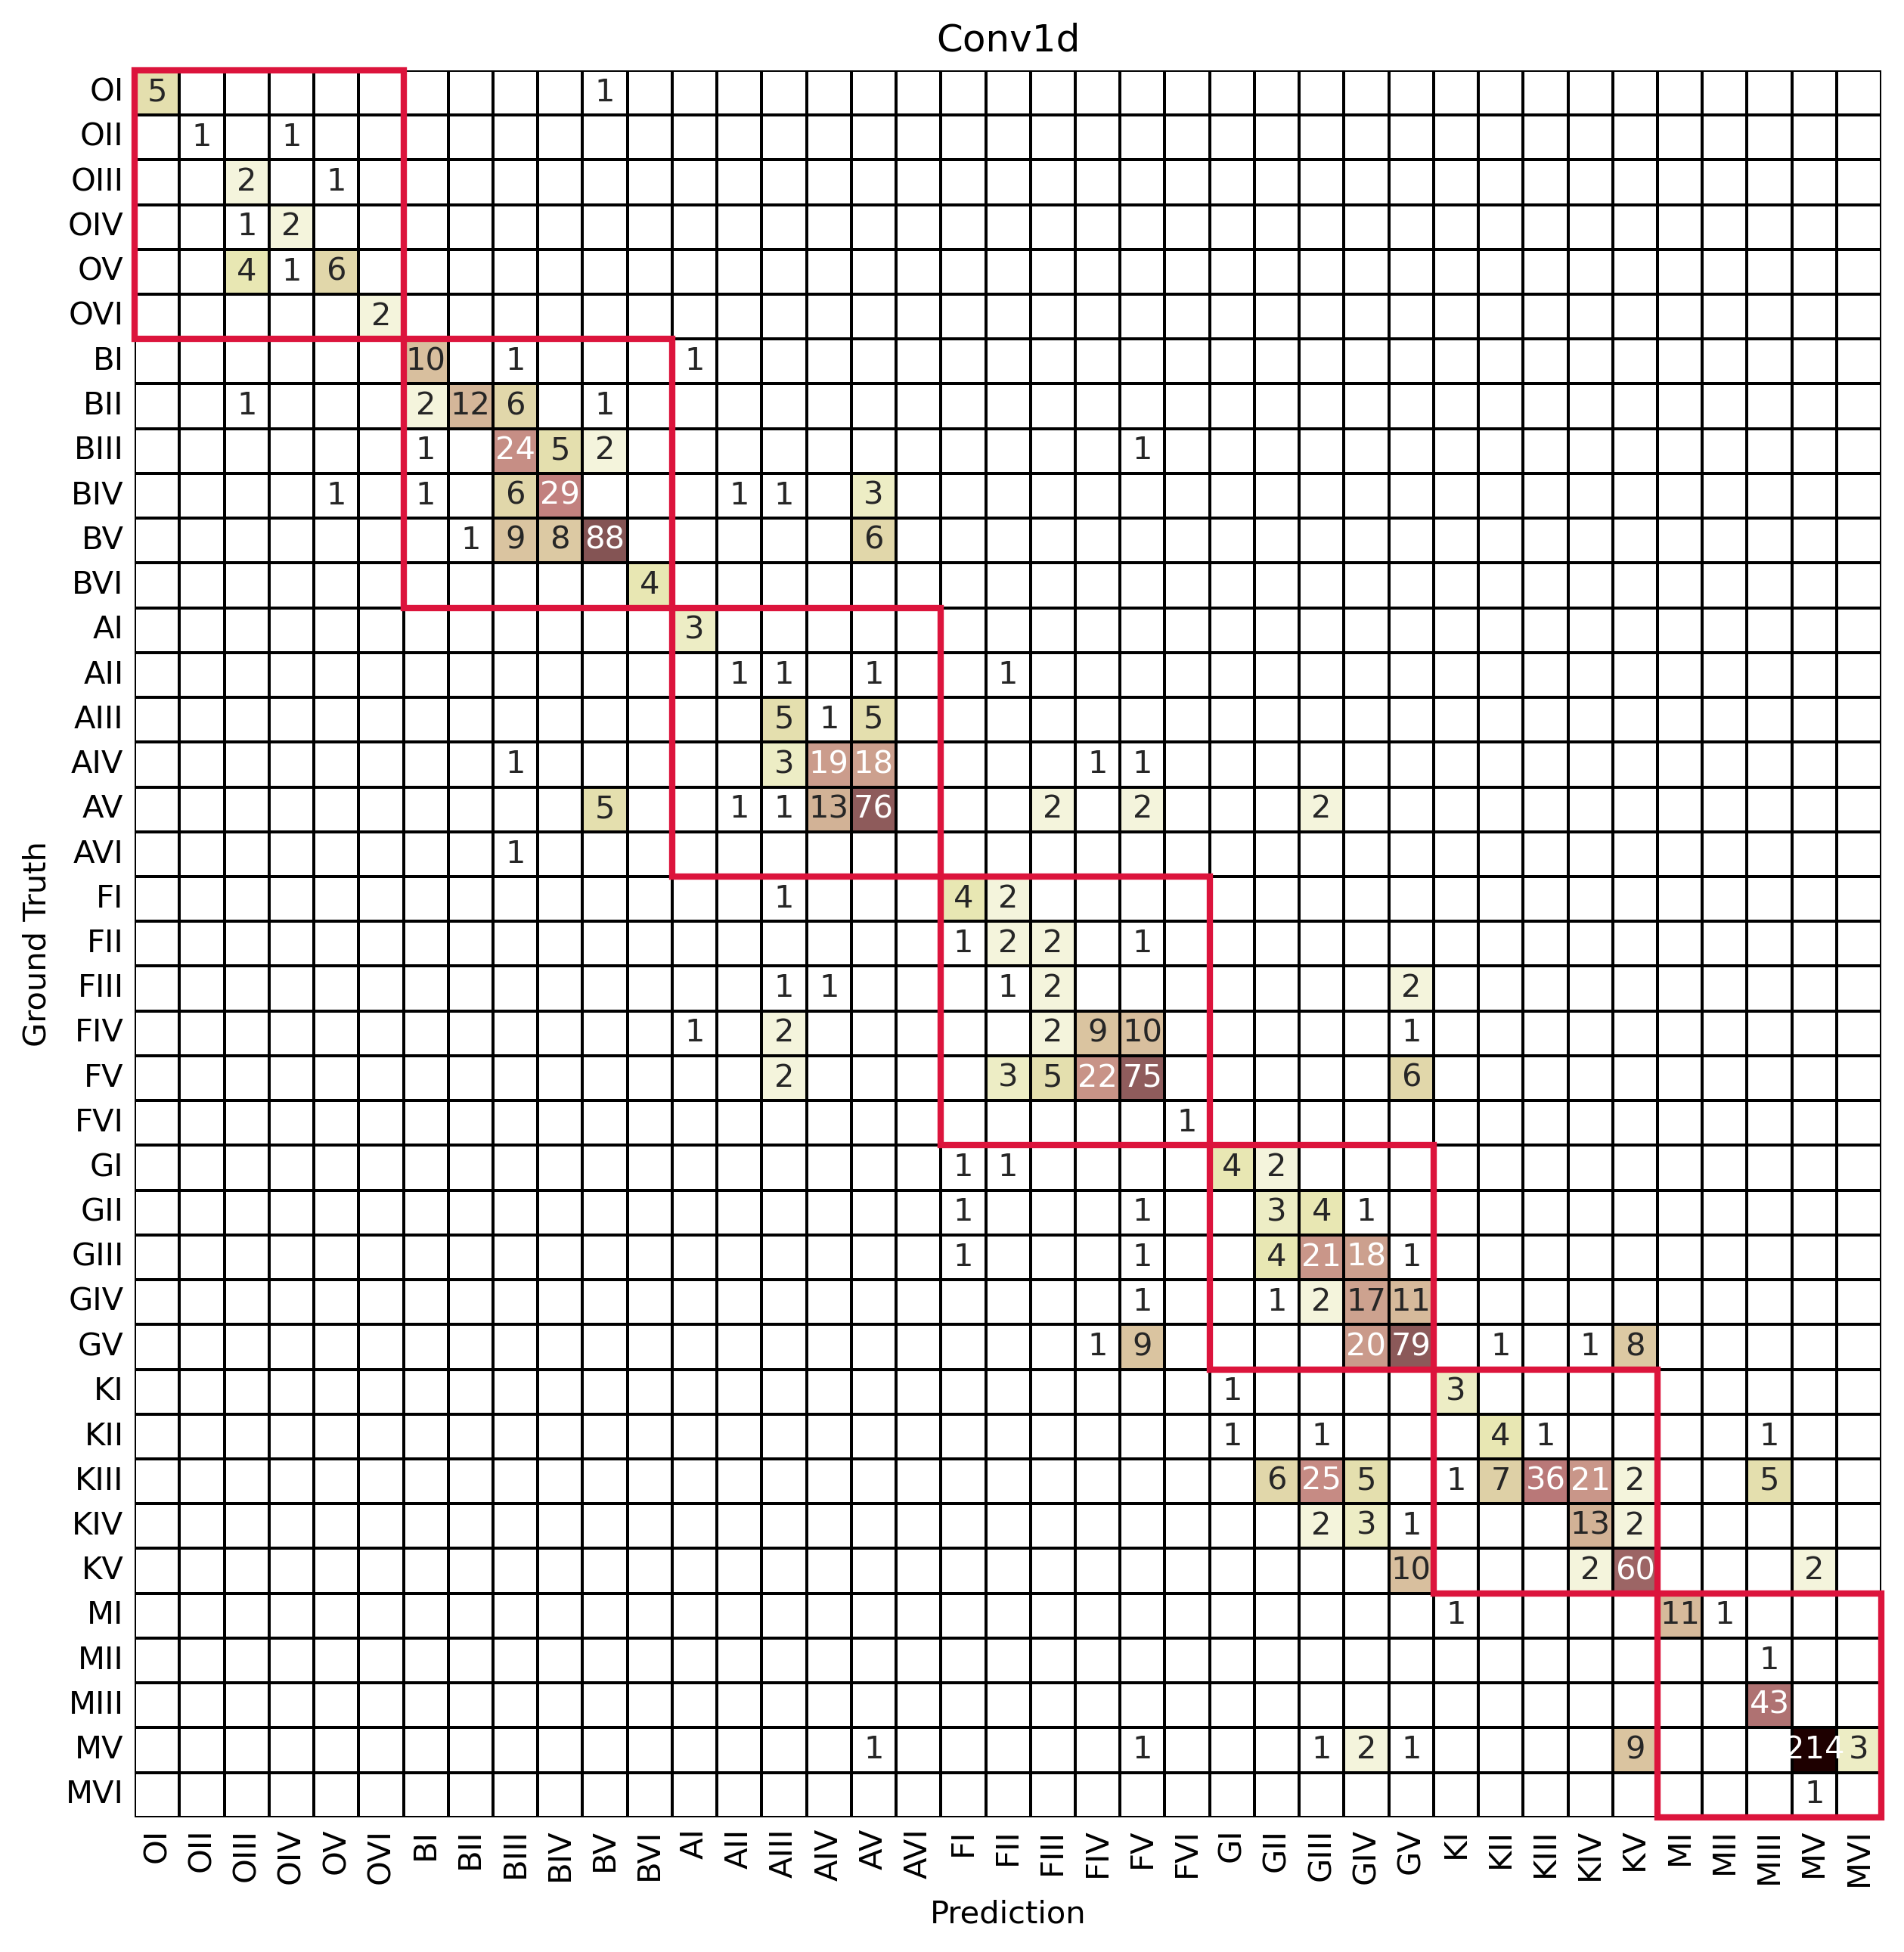

In [ ]:
preds, actuals = validator(test_loader, classifier3, custom_loss, test=True)
sm = stellar_metrics(label_f, preds, actuals, True, False)

sm.draw_cm('Conv1d', 300, False)

print(f'F1 Macro: {sm.f1_macro():.2%}')
print(f'Mean Absolute Error: {sm.mae():.2f}')
print(f'Q-Weighted Kappa: {sm.two_stage_qwk("q")[0]:.2%}, {sm.two_stage_qwk("q")[1]:.2%}')

In [ ]:
# path = 'models/weights/conv1d/cls/final6_test'
best_i = 69

classifier3 = ResNet1D50(
    num_classes=len(label_f.unique),
    in_channels=1
    ).to('cuda')
    
classifier3.load_state_dict(torch.load(f'{path}/best_conv1d_cls_{best_i}.pth.tar'))

<All keys matched successfully>

F1 Macro: 54.63%
Mean Absolute Error: 0.22
Q-Weighted Kappa: 96.42%, 59.17%


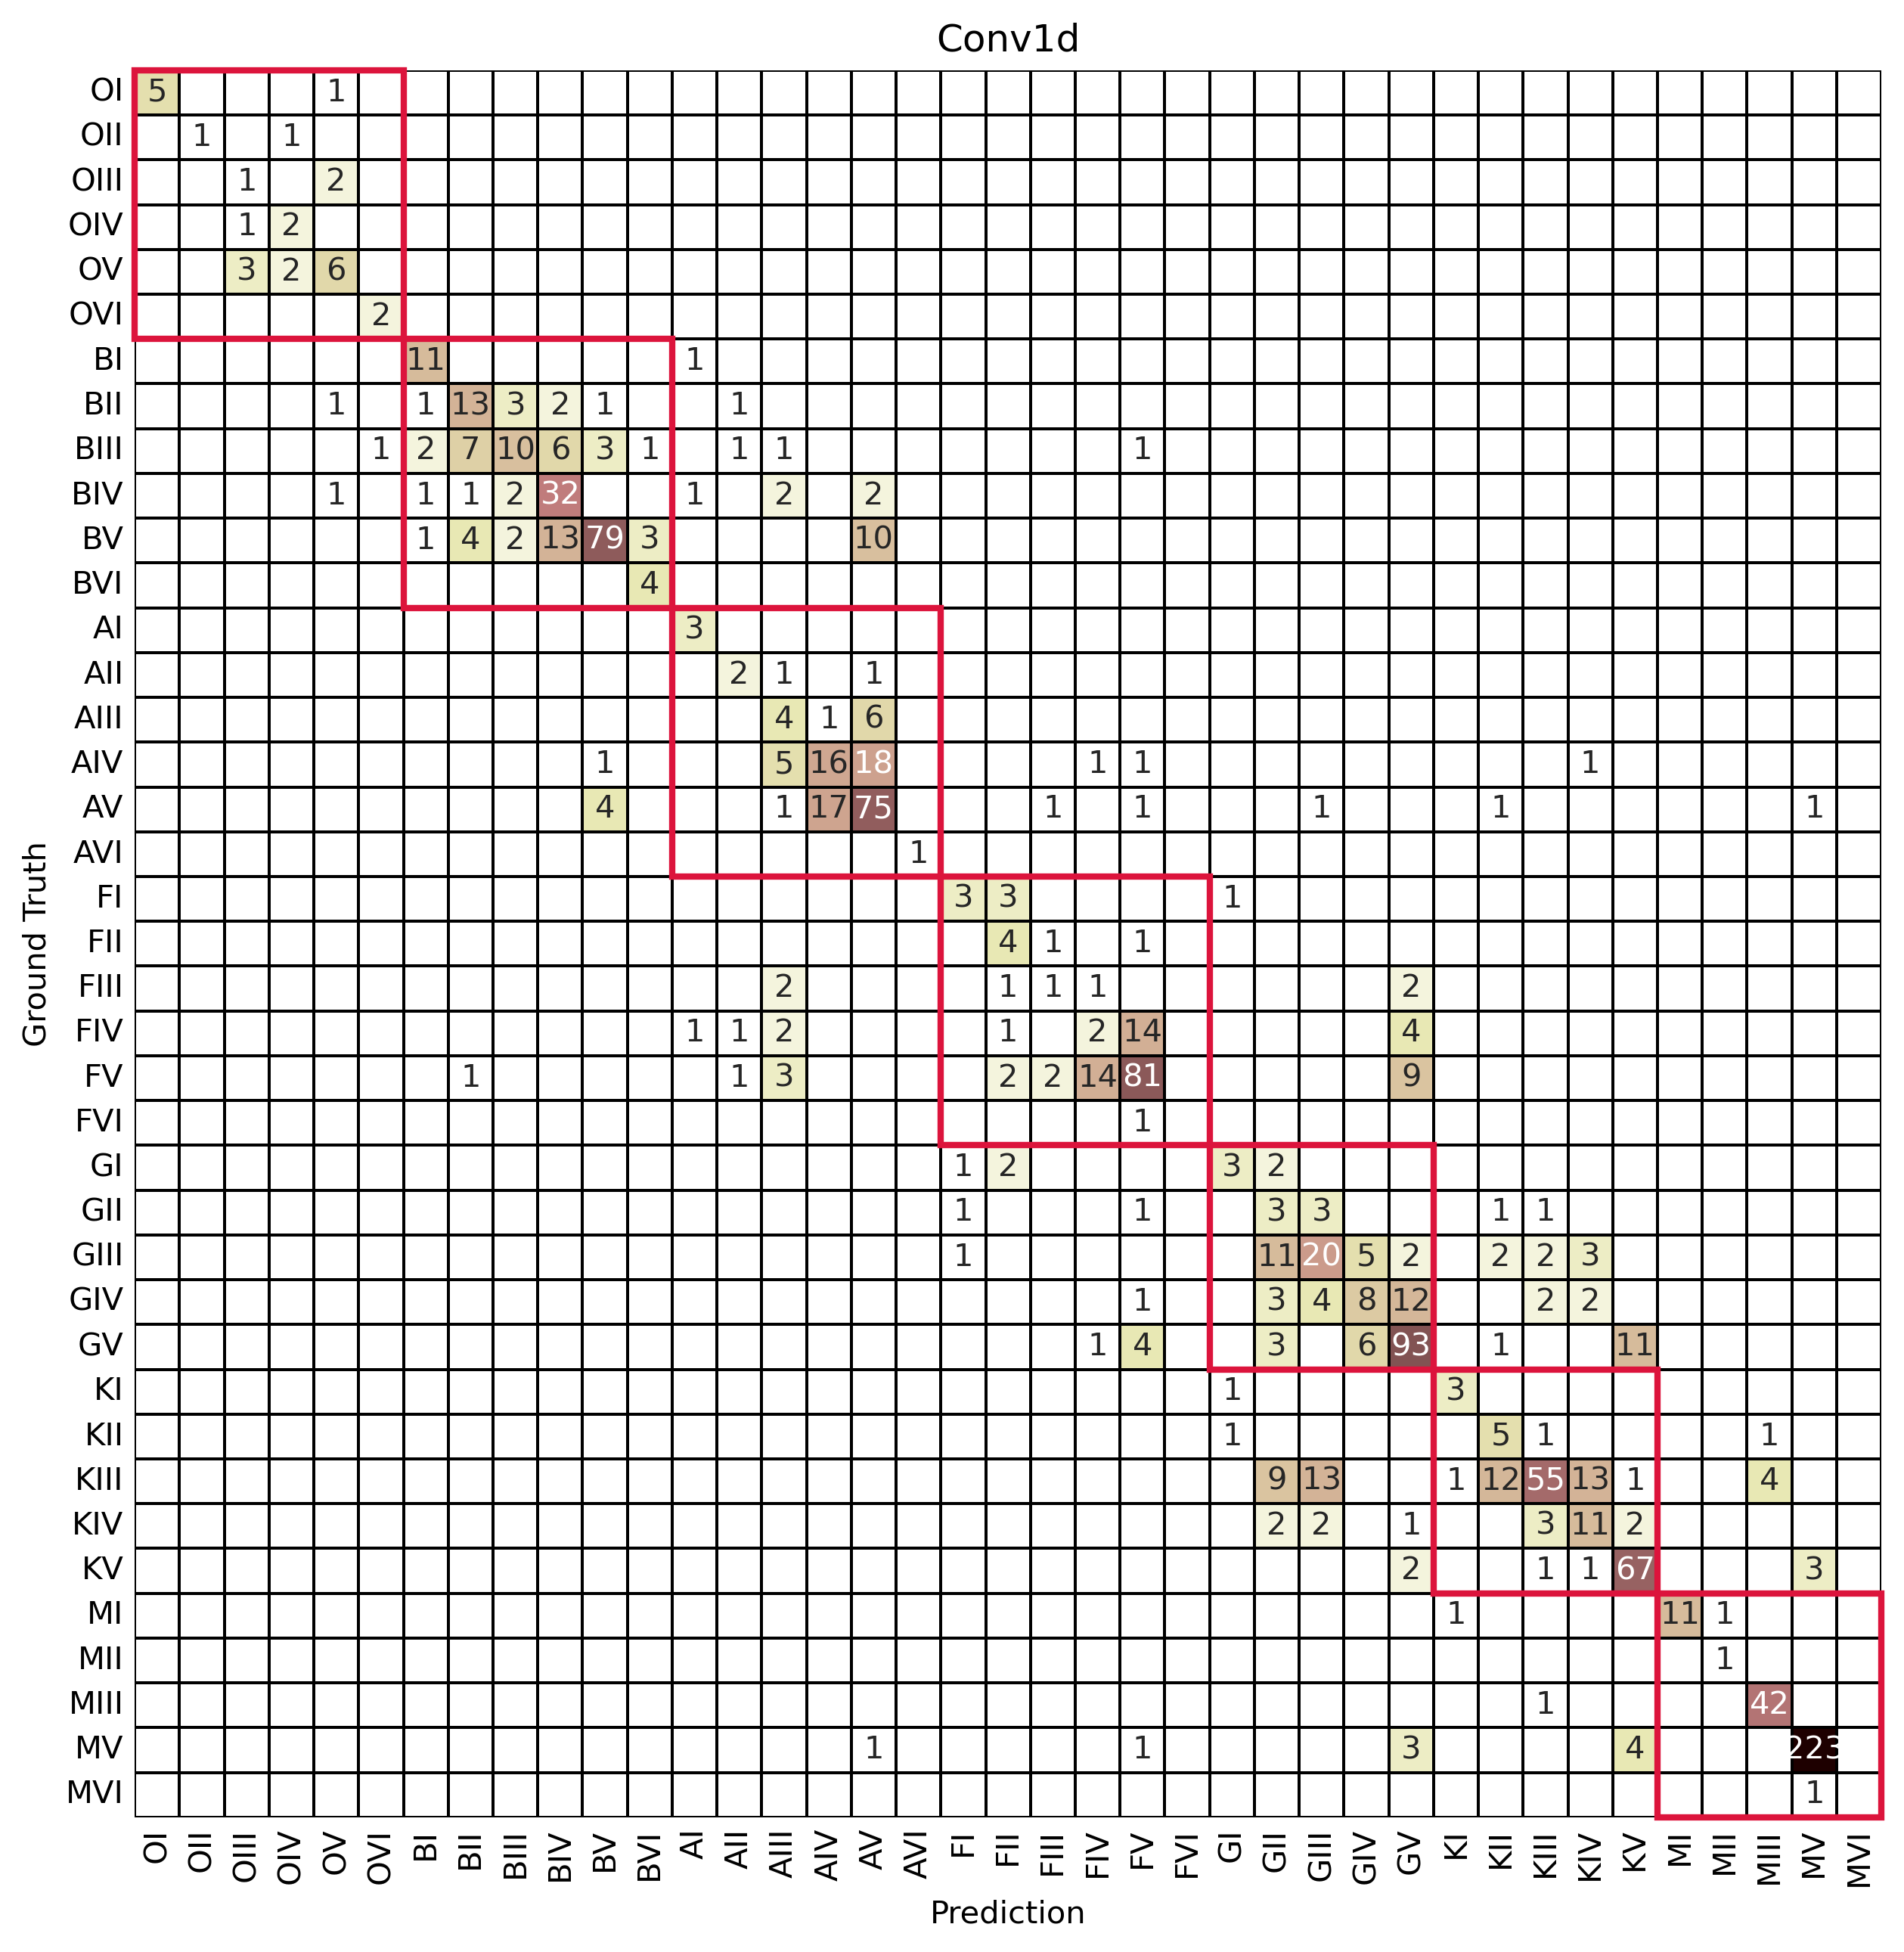

In [ ]:
preds, actuals = validator(test_loader, classifier3, custom_loss, test=True)
sm = stellar_metrics(label_f, preds, actuals, True, False)

sm.draw_cm('Conv1d', 300, False)

print(f'F1 Macro: {sm.f1_macro():.2%}')
print(f'Mean Absolute Error: {sm.mae():.2f}')
print(f'Q-Weighted Kappa: {sm.two_stage_qwk("q")[0]:.2%}, {sm.two_stage_qwk("q")[1]:.2%}')